Modules

In [ ]:
import numpy as np
import gzip
import matplotlib.pyplot as plt
import os
from google.colab import drive
from numpy import linalg

Data Pull

In [ ]:
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [ ]:
!ls "/content/gdrive/MyDrive/CS464/HW2 Dataset"

t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [ ]:
data_path1 = '/content/gdrive/MyDrive/CS464/HW2 Dataset/train-images-idx3-ubyte.gz'
data_path2 = '/content/gdrive/MyDrive/CS464/HW2 Dataset/train-labels-idx1-ubyte.gz'

In [ ]:
# Function to read pixel data from the dataset
def read_pixels(data_path):
    with gzip.open(data_path) as f:
        pixel_data = np.frombuffer(f.read(), 'B', offset=16).astype('float32')
    pixel_data = pixel_data.reshape(-1, 28*28)
    normalized_pixels = pixel_data / 255
    # Flatten each image to a 1D array (784 dimensions)
    flattened_pixels = normalized_pixels.reshape(-1, 784)

    return flattened_pixels

In [ ]:
# Function to read label data from the dataset
def read_labels(data_path):
    with gzip.open(data_path) as f:
        label_data = np.frombuffer(f.read(), 'B', offset=8)
    return label_data

In [ ]:
xtrain = read_pixels(data_path1)

In [ ]:
xtrain.shape

(60000, 784)

In [ ]:
ytrain = read_labels(data_path2)

In [ ]:
ytrain.shape

(60000,)

##PCA Analysis

#Question 1.1 and 1.2



In [ ]:
def PCA(train_data):
    # compute the mean
    mean = np.mean(train_data, axis=0, keepdims=True)
    train_centered = train_data - mean

    # Compute the covariance matrix:
    train_cov = np.cov(train_centered, rowvar = False)

    # Compute eigenvalus and eigenvectors
    vals, vects = linalg.eig(train_cov) # w: eigenvalues, v: eigenvector

    # get indexes of the top 10 largest eigenvalues
    index = np.argsort(vals)[::-1][:10] # already sorted in descending order
    print("indexes of the largest eigenvalues: ", index)

    # get corresponding eigenvectors (top 10 principal components)
    princ_comps = vects.T

    # proportion of explained variances
    total_variance = vals.sum()
    explained_vars = vals / total_variance
    print("PVE for each principal component:\n", explained_vars[:10])
    print("total variance explained by top 10 principal components: ", explained_vars[:10].sum())

    # find how many needed for at least %70 PVE
    cum_vars = np.cumsum(explained_vars)
    print("min number of principal components needed for >= %70 PVE: ", np.argwhere(cum_vars >= 0.7)[0,0] + 1)
    # Project data onto the first 2 principal components
    projected_data = np.dot(train_centered, princ_comps)
    return mean, princ_comps, projected_data

In [ ]:
mean, princ_comps, projected_data= PCA(xtrain)

indexes of the largest eigenvalues:  [0 1 2 3 4 5 6 7 8 9]
PVE for each principal component:
 [0.09704664 0.07095924 0.06169089 0.05389419 0.04868797 0.04312231
 0.0327193  0.02883895 0.02762029 0.02357001]
total variance explained by top 10 principal components:  0.4881498038548512
min number of principal components needed for >= %70 PVE:  26


The cumulative Proportion of Variance Explained (PVE) for the first 10 principal components amounted to approximately 48.8%. This finding emphesizes the significance of these initial components in capturing nearly half of the dataset's overall variance. Furthermore, a more comprehensive understanding of the dataset, encompassing 70% of its variance, was achieved by considering a larger set of principal components. Specifically, it was determined that a set of 26 principal components is required to explain 70% of the data. This insight highlights the trade-off between dimensionality reduction and information gain.

#Question 1.3

Let's visualise the reduced dimension images.

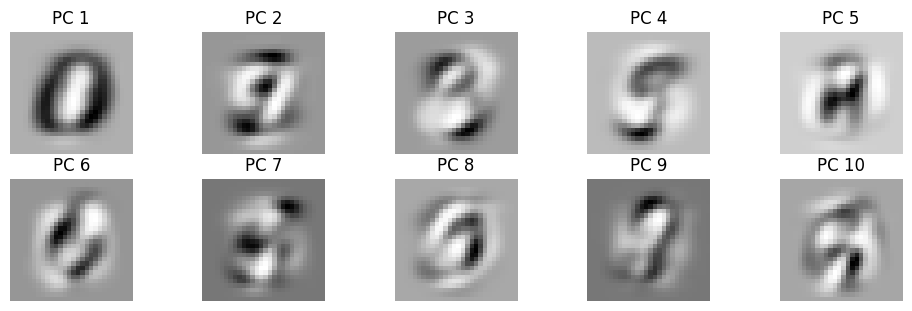

In [ ]:
# Reshape each principal component to a 28x28 matrix
principal_components_reshaped = princ_comps[:, :28*28].reshape(-1, 28, 28)

# Apply min-max scaling to each principal component
min_values = np.min(principal_components_reshaped, axis=(1, 2), keepdims=True)
max_values = np.max(principal_components_reshaped, axis=(1, 2), keepdims=True)
scaled_principal_components = (principal_components_reshaped - min_values) / (max_values - min_values)

# Display the obtained grayscale principal component images
plt.figure(figsize=(12, 3.5))
for i in range(10):  # Displaying the first 10 components
    plt.subplot(2, 5, i+1)
    plt.imshow(scaled_principal_components[i], cmap='Greys_r')
    plt.title(f'PC {i+1}')
    plt.axis('off')

plt.show()


The visualization of the first 10 principal components resulting from PCA offers insights into the essential features and structures within the dataset. After reshaping and min-max scaling to ensure values fall within the [0, 1] range, the grayscale images reveal distinct patterns. The first component likely captures the primary source of variance, with subsequent components capturing diminishing amounts. These patterns may represent specific features or textures in the original data. The visualization serves as a qualitative assessment of PCA's effectiveness in summarizing dataset variability and provides a foundation for further analysis, facilitating dimensionality reduction and the identification of key data features.

#Question 1.4

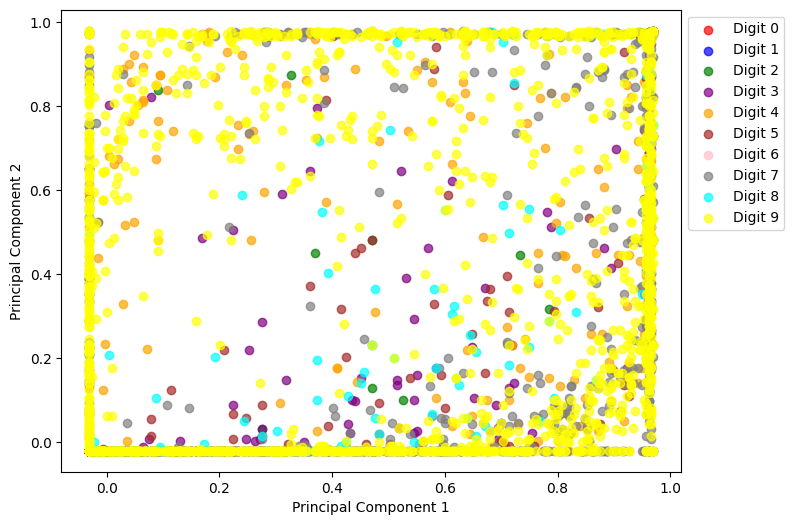

In [ ]:
# Create a color map for different labels
label_colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'purple', 4: 'orange',
                5: 'brown', 6: 'pink', 7: 'gray', 8: 'cyan', 9: 'yellow'}

plt.figure(figsize=(8, 6))
for label in np.unique(ytrain):
    indices = np.where(ytrain == label)[0]
    plt.scatter(projected_data[indices, 0], projected_data[indices, 1],
                color=label_colors[label], label=f'Digit {label}', alpha=0.7)

# Label the axes
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

#Question 1.5

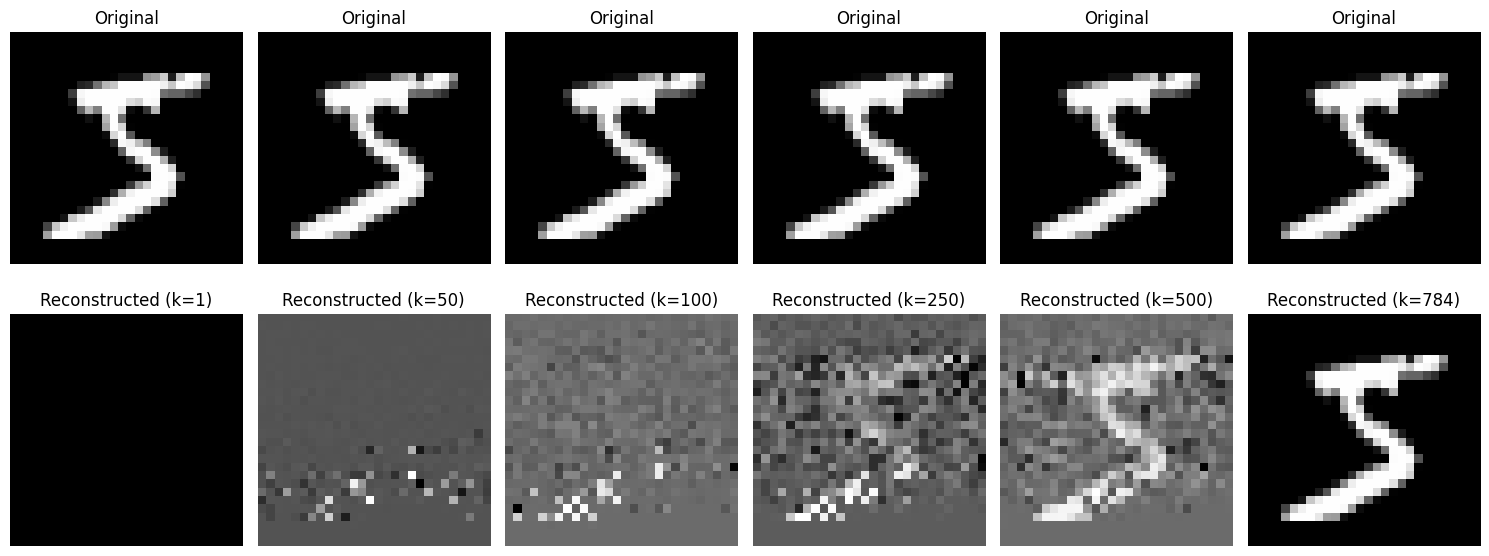

In [ ]:
img1 = xtrain[0:1]
# Function to reconstruct an image using k principal components
def reconstruct_image(orig_img, princ_comps, k):
    # Select the first k principal components
    selected_components = princ_comps[:, :k]

    # Project the original image onto the selected components
    projection_coefficients = np.dot(orig_img, selected_components)

    # Reconstruct the image using the projection coefficients and selected components
    reconstructed_image = np.dot(projection_coefficients, selected_components.T)

    return reconstructed_image

# Values of k
k_values = [1, 50, 100, 250, 500, 784]

# Plot the original and reconstructed images for each k
plt.figure(figsize=(15, 6))
for i, k in enumerate(k_values, 1):
    # Reconstruct the image for the current k
    reconstructed_image = reconstruct_image(img1, princ_comps, k)

    # Plot the original image
    plt.subplot(2, 6, i)
    plt.imshow(img1.reshape(28, 28), cmap='Greys_r')
    plt.title('Original')
    plt.axis('off')

    # Plot the reconstructed image
    plt.subplot(2, 6, i + 6)
    plt.imshow(reconstructed_image.reshape(28, 28), cmap='Greys_r')
    plt.title(f'Reconstructed (k={k})')
    plt.axis('off')

plt.tight_layout()
plt.show()


Exploring different values of "k" in PCA-based image reconstruction highlights the trade-off between compression and precision. Smaller values of "k," like 1, result in highly compressed but somewhat blurred reconstructions. As "k" increases, fidelity improves, with a balanced representation achieved around "k = 250," offering substantial detail while maintaining computational efficiency. However, further increases in "k" lead to nearly perfect reconstructions, approaching the total number of components (k = 784), at the expense of losing the benefits of dimensionality reduction. The choice of the optimal "k" depends on careful consideration of application requirements, balancing storage and processing efficiency against the desire for high-fidelity reconstructions.

##Logistic Regression

Data pull

In [ ]:
!ls "/content/gdrive/MyDrive/CS464/HW2 Dataset"

t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [ ]:
data_path3 = '/content/gdrive/MyDrive/CS464/HW2 Dataset/t10k-images-idx3-ubyte.gz'
data_path4 = '/content/gdrive/MyDrive/CS464/HW2 Dataset/t10k-labels-idx1-ubyte.gz'

In [ ]:
# One-hot encoding of the labels
def one_hot_encoding(label_data):
    unique_labels = sorted(set(label_data))
    num_classes = len(unique_labels)
    encoded_labels = []
    for label in label_data:
        encoding = [0] * num_classes
        encoding[unique_labels.index(label)] = 1
        encoded_labels.append(encoding)
    encoded_labels = np.array(encoded_labels)
    return encoded_labels

# Function to read label data from the dataset
def read_labels2(data_path):
    with gzip.open(data_path) as f:
        label_data = np.frombuffer(f.read(), 'B', offset=8)
    one_hot_encoding_labels = one_hot_encoding(label_data)
    return one_hot_encoding_labels

In [ ]:
X_train = read_pixels(data_path1)
y_train = read_labels2(data_path2)
X_test = read_pixels(data_path3)
y_test = read_labels2(data_path4)

In [ ]:
# Separate the first 10,000 images and labels for validation
X_val = X_train[:10000]
y_val = y_train[:10000]

# Update the training data and labels by excluding the validation set
X_train = X_train[10000:]
y_train = y_train[10000:]

#Question 2.1

In [ ]:
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred, weights, reg_coeff):
    m = len(y_true)
    epsilon = 1e-10  # Small constant to avoid division by zero
    cross_entropy = -np.sum(np.log(y_pred[range(m)] * y_true + epsilon)) #if predicted true, this value will decrease
    regularization_term = 0.5 * reg_coeff * np.sum(weights**2)
    return cross_entropy + regularization_term

def gradient_descent(X, y, weights, learning_rate, reg_coeff, epochs, batch_size):
    m, n = X.shape
    num_classes = len(np.unique(y))

    for epoch in range(epochs):
        for i in range(0, m, batch_size):
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]

            # Forward pass
            scores = np.dot(X_batch, weights)
            probabilities = softmax(scores)

            # Compute the gradient of the cross-entropy loss with respect to the weights
            grad = -np.dot(X_batch.T, (y_batch - probabilities))
            grad += reg_coeff * weights

            # Update weights
            weights -= learning_rate * grad

        # Compute the loss after each epoch
        y_pred = softmax(np.dot(X, weights))
        loss = cross_entropy_loss(y, y_pred, weights, reg_coeff)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss}")

    return weights

Train the model with one loop in gradient descent function (Initial parameters).

In [ ]:
# Initialize parameters
np.random.seed(42)
weights = np.random.normal(loc=0, scale=1, size=(784, 10))
learning_rate = 5e-4
reg_coeff = 1e-4
epochs = 100
batch_size = 200

# Train the logistic regression model
trained_weights = gradient_descent(X_train, y_train, weights, learning_rate, reg_coeff, epochs, batch_size)

Epoch 1/100, Loss: 10467436.782789527
Epoch 2/100, Loss: 10431940.625300838
Epoch 3/100, Loss: 10419474.484890416
Epoch 4/100, Loss: 10412585.953408293
Epoch 5/100, Loss: 10408030.80012982
Epoch 6/100, Loss: 10404722.519150607
Epoch 7/100, Loss: 10402171.644640682
Epoch 8/100, Loss: 10400124.25239999
Epoch 9/100, Loss: 10398432.06195763
Epoch 10/100, Loss: 10397001.154331136
Epoch 11/100, Loss: 10395769.311935624
Epoch 12/100, Loss: 10394693.701140862
Epoch 13/100, Loss: 10393743.689232314
Epoch 14/100, Loss: 10392896.569402106
Epoch 15/100, Loss: 10392134.99576899
Epoch 16/100, Loss: 10391445.418326465
Epoch 17/100, Loss: 10390817.07571457
Epoch 18/100, Loss: 10390241.30439637
Epoch 19/100, Loss: 10389711.044351002
Epoch 20/100, Loss: 10389220.478498686
Epoch 21/100, Loss: 10388764.767810203
Epoch 22/100, Loss: 10388339.854587412
Epoch 23/100, Loss: 10387942.313031664
Epoch 24/100, Loss: 10387569.232780626
Epoch 25/100, Loss: 10387218.126413936
Epoch 26/100, Loss: 10386886.85522439
Ep

Make Predictions with X_test for first question. (X_val is not used yet)

In [ ]:
# Use the trained weights to compute the predicted probabilities for the test set
y_pred_probs = softmax(np.dot(X_test, trained_weights))
# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

In [ ]:
def confusion_matrix(y_true, y_pred, num_classes):
    matrix = [[0] * num_classes for _ in range(num_classes)]
    correct_predictions = 0

    for true_label, pred_label in zip(y_true, y_pred):
        matrix[pred_label][true_label] += 1
        if true_label == pred_label:
            correct_predictions += 1

    accuracy = correct_predictions / len(y_true)
    return matrix, accuracy

In [ ]:
# Assuming num_classes is the number of unique classes in your data
num_classes = len(set(y_true_labels))

# Create the confusion matrix and calculate accuracy
conf_matrix, accuracy = confusion_matrix(y_true_labels, y_pred_labels, num_classes)

# Print the confusion matrix
print("Confusion Matrix:")
for row in conf_matrix:
    print(row)

# Print accuracy
print("Accuracy:", accuracy)

Confusion Matrix:
[952, 0, 4, 3, 0, 12, 19, 1, 7, 9]
[0, 1100, 12, 0, 2, 2, 3, 8, 10, 8]
[2, 7, 904, 22, 4, 3, 8, 23, 6, 1]
[2, 4, 21, 897, 6, 40, 1, 8, 21, 7]
[2, 0, 12, 1, 885, 12, 13, 7, 11, 31]
[7, 1, 7, 35, 3, 756, 22, 1, 34, 11]
[6, 4, 11, 3, 14, 18, 887, 0, 11, 0]
[3, 3, 15, 11, 4, 8, 0, 933, 10, 22]
[3, 16, 40, 29, 8, 33, 5, 10, 848, 13]
[3, 0, 6, 9, 56, 8, 0, 37, 16, 907]
Accuracy: 0.9069


#Question 2.2

For tuning of the model, validation dataset will be used in calculation of accuracy.

In [ ]:
def accuracy(trained_weights):
    y_pred_probs = softmax(np.dot(X_val, trained_weights))
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_val, axis=1)
    correct_predictions = 0
    for true_label, pred_label in zip(y_true, y_pred):
        if true_label == pred_label:
            correct_predictions += 1
    accuracy = correct_predictions / len(y_true)
    return accuracy




*  Batch Size




In [ ]:
# Initialize parameters
np.random.seed(42)
weights = np.random.normal(loc=0, scale=1, size=(784, 10))
learning_rate = 5e-4
reg_coeff = 1e-4

In [ ]:
batch_sizes = [1,64,50000]

scatter_batch_sizes = []
scatter_accuracies = []

# Train models and collect accuracy for each batch size
for batch_size in batch_sizes:
    print("Another Batch Size")
    trained_weights = gradient_descent(X_train, y_train, weights, learning_rate, reg_coeff, epochs, batch_size)
    accur = accuracy(trained_weights)
    # Store data for scatter plot
    scatter_batch_sizes.append(batch_size)
    scatter_accuracies.append(accur)

Another Batch Size
Epoch 1/100, Loss: 10467282.95875406
Epoch 2/100, Loss: 10431615.863452422
Epoch 3/100, Loss: 10419060.561149096
Epoch 4/100, Loss: 10412102.472023983
Epoch 5/100, Loss: 10407487.592674116
Epoch 6/100, Loss: 10404125.679190105
Epoch 7/100, Loss: 10401526.025890434
Epoch 8/100, Loss: 10399433.773184372
Epoch 9/100, Loss: 10397699.853531038
Epoch 10/100, Loss: 10396229.908313178
Epoch 11/100, Loss: 10394961.467903184
Epoch 12/100, Loss: 10393851.502826892
Epoch 13/100, Loss: 10392869.178584587
Epoch 14/100, Loss: 10391991.578028234
Epoch 15/100, Loss: 10391201.16244469
Epoch 16/100, Loss: 10390484.219848314
Epoch 17/100, Loss: 10389829.854502823
Epoch 18/100, Loss: 10389229.288588287
Epoch 19/100, Loss: 10388675.36328193
Epoch 20/100, Loss: 10388162.1771155
Epoch 21/100, Loss: 10387684.82083693
Epoch 22/100, Loss: 10387239.179235036
Epoch 23/100, Loss: 10386821.779415976
Epoch 24/100, Loss: 10386429.672149956
Epoch 25/100, Loss: 10386060.33752515
Epoch 26/100, Loss: 10

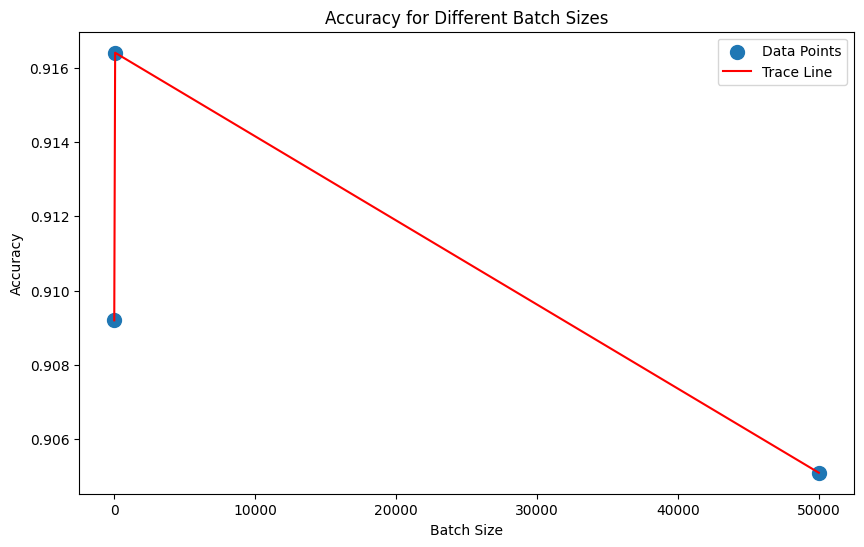

In [ ]:
# Reshape lists for easy plotting
scatter_batch_sizes = np.array(scatter_batch_sizes)
scatter_accuracies = np.array(scatter_accuracies)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(scatter_batch_sizes, scatter_accuracies, s=100, marker='o', label='Data Points')
plt.plot(scatter_batch_sizes, scatter_accuracies, linestyle='-', marker='', color='red', label='Trace Line')
plt.title('Accuracy for Different Batch Sizes')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



*   Weight Initialization Technique


In [ ]:
np.random.seed(42)
learning_rate = 5e-4
reg_coeff = 1e-4
batch_size = 200

In [ ]:
weights_dict = {
    "Zero" : np.zeros((784, 10)),
    "Uniform" : np.random.uniform(0,1,(784,10)),
    "Normal" : np.random.normal(loc=0, scale=1, size=(784, 10))
    }

scatter_weights = []
scatter_accuracies = []

for weight_name, weight_formula in weights_dict.items():
    trained_weights = gradient_descent(X_train, y_train, weight_formula, learning_rate, reg_coeff, epochs, batch_size)
    accur = accuracy(trained_weights)
    scatter_weights.append(weight_name)
    scatter_accuracies.append(accur)

Epoch 1/100, Loss: 10384934.252061723
Epoch 2/100, Loss: 10381591.56796556
Epoch 3/100, Loss: 10380160.257235982
Epoch 4/100, Loss: 10379314.124477686
Epoch 5/100, Loss: 10378737.554741014
Epoch 6/100, Loss: 10378311.525240319
Epoch 7/100, Loss: 10377979.705762755
Epoch 8/100, Loss: 10377711.473597053
Epoch 9/100, Loss: 10377488.540146625
Epoch 10/100, Loss: 10377299.213424427
Epoch 11/100, Loss: 10377135.622907788
Epoch 12/100, Loss: 10376992.251739973
Epoch 13/100, Loss: 10376865.104633287
Epoch 14/100, Loss: 10376751.209284682
Epoch 15/100, Loss: 10376648.303815532
Epoch 16/100, Loss: 10376554.63333428
Epoch 17/100, Loss: 10376468.813266898
Epoch 18/100, Loss: 10376389.73502536
Epoch 19/100, Loss: 10376316.499358028
Epoch 20/100, Loss: 10376248.368286202
Epoch 21/100, Loss: 10376184.729812682
Epoch 22/100, Loss: 10376125.071588833
Epoch 23/100, Loss: 10376068.960980935
Epoch 24/100, Loss: 10376016.029782748
Epoch 25/100, Loss: 10375965.962351916
Epoch 26/100, Loss: 10375918.48630306

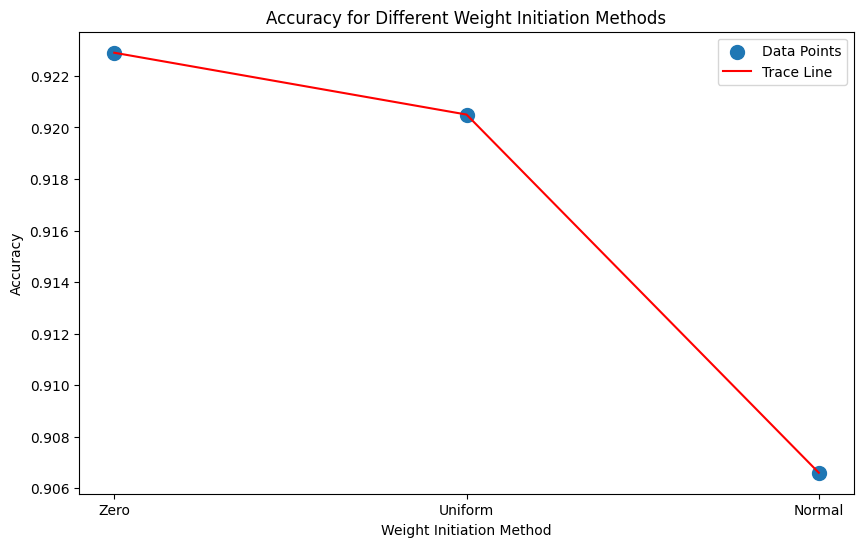

In [ ]:
scatter_weights = np.array(scatter_weights)
scatter_accuracies = np.array(scatter_accuracies)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(scatter_weights, scatter_accuracies, s=100, marker='o', label='Data Points')
plt.plot(scatter_weights, scatter_accuracies, linestyle='-', marker='', color='red', label='Trace Line')
plt.title('Accuracy for Different Weight Initiation Methods')
plt.xlabel('Weight Initiation Method')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



*   Learning Rate



In [ ]:
np.random.seed(42)
weights = np.random.normal(loc=0, scale=1, size=(784, 10))
reg_coeff = 1e-4
batch_size = 200
learn_rates = [1e-1,1e-3,1e-4,1e-5]

In [ ]:
scatter_learn_rates = []
scatter_accuracies = []

for learn_rate in learn_rates:
    trained_weights = gradient_descent(X_train, y_train, weights, learn_rate, reg_coeff, epochs, batch_size)
    accur = accuracy(trained_weights)
    scatter_learn_rates.append(learn_rate)
    scatter_accuracies.append(accur)

Epoch 1/100, Loss: 10480201.880825335
Epoch 2/100, Loss: 10468610.80710101
Epoch 3/100, Loss: 10453529.483633073
Epoch 4/100, Loss: 10452873.80381137
Epoch 5/100, Loss: 10445686.678666648
Epoch 6/100, Loss: 10456288.668872226
Epoch 7/100, Loss: 10449899.996400356
Epoch 8/100, Loss: 10446241.656223027
Epoch 9/100, Loss: 10463805.515290627
Epoch 10/100, Loss: 10457738.164935715
Epoch 11/100, Loss: 10443862.191703094
Epoch 12/100, Loss: 10444544.14654271
Epoch 13/100, Loss: 10447283.86262064
Epoch 14/100, Loss: 10452432.844334064
Epoch 15/100, Loss: 10448620.875097506
Epoch 16/100, Loss: 10456788.720847232
Epoch 17/100, Loss: 10442095.232486801
Epoch 18/100, Loss: 10450079.269073525
Epoch 19/100, Loss: 10435699.570860473
Epoch 20/100, Loss: 10451176.974081162
Epoch 21/100, Loss: 10441123.099677792
Epoch 22/100, Loss: 10451368.523182554
Epoch 23/100, Loss: 10437896.545338526
Epoch 24/100, Loss: 10445013.28333438
Epoch 25/100, Loss: 10437998.823533278
Epoch 26/100, Loss: 10447282.844110126


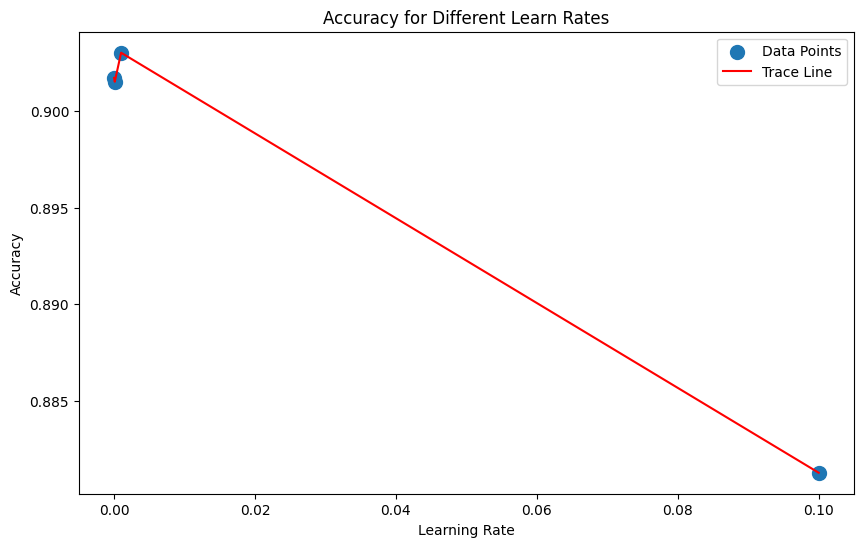

In [ ]:
scatter_learn_rates = np.array(scatter_learn_rates)
scatter_accuracies = np.array(scatter_accuracies)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(scatter_learn_rates, scatter_accuracies, s=100, marker='o', label='Data Points')
plt.plot(scatter_learn_rates, scatter_accuracies, linestyle='-', marker='', color='red', label='Trace Line')
plt.title('Accuracy for Different Learn Rates')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



*   Regularization Coefficient



In [ ]:
np.random.seed(42)
weights = np.random.normal(loc=0, scale=1, size=(784, 10))
learning_rate = 5e-4
batch_size = 200
reg_coefs = [1e-2,1e-4,1e-9]

In [ ]:
scatter_reg_coefs = []
scatter_accuracies = []

for reg_coef in reg_coefs:
    trained_weights = gradient_descent(X_train, y_train, weights, learning_rate, reg_coef, epochs, batch_size)
    accur = accuracy(trained_weights)
    scatter_reg_coefs.append(reg_coef)
    scatter_accuracies.append(accur)

Epoch 1/100, Loss: 10467321.041145567
Epoch 2/100, Loss: 10431794.176615356
Epoch 3/100, Loss: 10419294.638051568
Epoch 4/100, Loss: 10412374.915425839
Epoch 5/100, Loss: 10407791.387674388
Epoch 6/100, Loss: 10404456.947101321
Epoch 7/100, Loss: 10401881.869967617
Epoch 8/100, Loss: 10399811.952606734
Epoch 9/100, Loss: 10398098.623620685
Epoch 10/100, Loss: 10396647.801923499
Epoch 11/100, Loss: 10395397.178552099
Epoch 12/100, Loss: 10394303.843266116
Epoch 13/100, Loss: 10393337.078033198
Epoch 14/100, Loss: 10392474.082717437
Epoch 15/100, Loss: 10391697.422721278
Epoch 16/100, Loss: 10390993.47124425
Epoch 17/100, Loss: 10390351.401886567
Epoch 18/100, Loss: 10389762.495199127
Epoch 19/100, Loss: 10389219.642372545
Epoch 20/100, Loss: 10388716.984011492
Epoch 21/100, Loss: 10388249.64518469
Epoch 22/100, Loss: 10387813.53825229
Epoch 23/100, Loss: 10387405.21249489
Epoch 24/100, Loss: 10387021.736648023
Epoch 25/100, Loss: 10386660.60561142
Epoch 26/100, Loss: 10386319.66565396
E

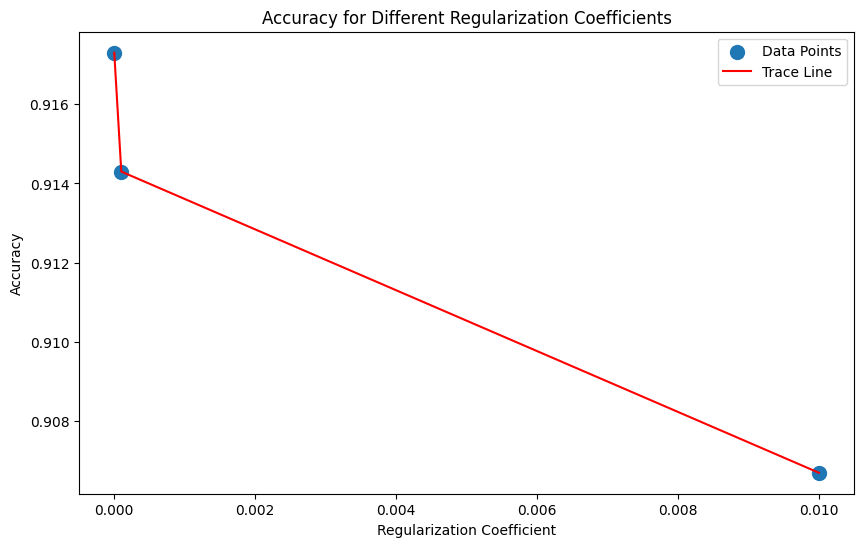

In [ ]:
scatter_reg_coefs = np.array(scatter_reg_coefs)
scatter_accuracies = np.array(scatter_accuracies)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(scatter_reg_coefs, scatter_accuracies, s=100, marker='o', label='Data Points')
plt.plot(scatter_reg_coefs, scatter_accuracies, linestyle='-', marker='', color='red', label='Trace Line')
plt.title('Accuracy for Different Regularization Coefficients')
plt.xlabel('Regularization Coefficient')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Question 2.3

The best performing parameters are, x,x,x,x,x,x for weight initialization, learning rate, regularization coefficient, epochs and batch size among all trials.

In [ ]:
weights = np.zeros((784, 10))
learning_rate = 5e-4
reg_coeff = 1e-4
epochs = 100
batch_size = 200

Train the model

In [ ]:
trained_weights_best = gradient_descent(X_train, y_train, weights, learn_rate, reg_coeff, epochs, batch_size)

Epoch 1/100, Loss: 10454695.601082895
Epoch 2/100, Loss: 10439553.129796572
Epoch 3/100, Loss: 10429031.67348668
Epoch 4/100, Loss: 10421536.363495117
Epoch 5/100, Loss: 10416013.488194387
Epoch 6/100, Loss: 10411805.116204374
Epoch 7/100, Loss: 10408501.139430046
Epoch 8/100, Loss: 10405840.064156989
Epoch 9/100, Loss: 10403650.017230747
Epoch 10/100, Loss: 10401814.464482613
Epoch 11/100, Loss: 10400252.051004468
Epoch 12/100, Loss: 10398904.454179624
Epoch 13/100, Loss: 10397728.857472675
Epoch 14/100, Loss: 10396693.155044612
Epoch 15/100, Loss: 10395772.814111866
Epoch 16/100, Loss: 10394948.770732243
Epoch 17/100, Loss: 10394205.98631897
Epoch 18/100, Loss: 10393532.436688934
Epoch 19/100, Loss: 10392918.390519466
Epoch 20/100, Loss: 10392355.885390257
Epoch 21/100, Loss: 10391838.341247443
Epoch 22/100, Loss: 10391360.271092802
Epoch 23/100, Loss: 10390917.061550785
Epoch 24/100, Loss: 10390504.804393245
Epoch 25/100, Loss: 10390120.165726481
Epoch 26/100, Loss: 10389760.2833624

In [ ]:
# Use the trained weights to compute the predicted probabilities for the test set
y_pred_probs = softmax(np.dot(X_test, trained_weights))
# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

In [ ]:
# Assuming num_classes is the number of unique classes in your data
num_classes = len(set(y_true_labels))

# Create the confusion matrix and calculate accuracy
conf_matrix, accuracy = confusion_matrix(y_true_labels, y_pred_labels, num_classes)

# Print the confusion matrix
print("Confusion Matrix for best performing model:")
for row in conf_matrix:
    print(row)

# Print accuracy
print("Accuracy for best performing model:", accuracy)

Confusion Matrix for best performing model:
[955, 0, 7, 3, 0, 11, 14, 1, 6, 9]
[0, 1105, 11, 0, 1, 1, 3, 7, 10, 8]
[2, 4, 915, 21, 7, 3, 4, 21, 6, 1]
[1, 3, 17, 919, 3, 36, 2, 7, 22, 8]
[3, 1, 9, 0, 908, 13, 8, 6, 8, 24]
[8, 1, 5, 27, 1, 771, 23, 0, 32, 7]
[5, 4, 12, 3, 12, 13, 899, 0, 11, 0]
[4, 2, 11, 10, 3, 6, 2, 947, 8, 16]
[1, 15, 41, 21, 8, 32, 3, 6, 858, 10]
[1, 0, 4, 6, 39, 6, 0, 33, 13, 926]
Accuracy for best performing model: 0.9203


# Question 2.4

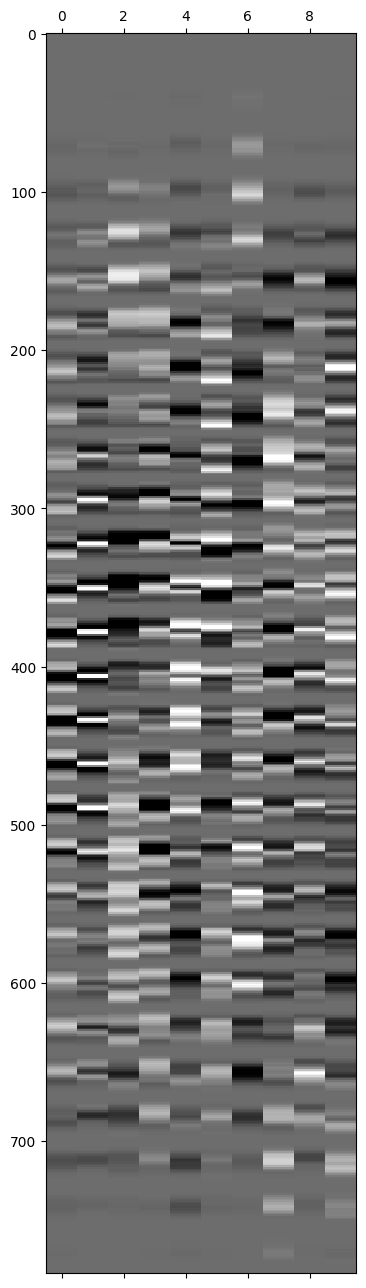

In [ ]:
plt.matshow(trained_weights_best, cmap=plt.cm.gray, vmin=0.5*trained_weights_best.min(), vmax=0.5*trained_weights_best.max(), aspect='auto')

#Question 2.5

In [ ]:
def calculate_metrics_from_confusion_matrix(conf_matrix_and_accuracy):
    conf_matrix, accuracy = conf_matrix_and_accuracy
    num_classes = len(conf_matrix)

    precision = np.zeros(num_classes, dtype=float)
    recall = np.zeros(num_classes, dtype=float)
    f1_score = np.zeros(num_classes, dtype=float)
    f2_score = np.zeros(num_classes, dtype=float)

    epsilon = 1e-9  # a small constant to avoid division by zero

    for i in range(num_classes):
        true_positive = conf_matrix[i][i]
        false_positive = sum(conf_matrix[j][i] for j in range(num_classes)) - true_positive
        false_negative = sum(conf_matrix[i][j] for j in range(num_classes)) - true_positive

        # Precision
        precision[i] = true_positive / (true_positive + false_positive + epsilon)

        # Recall
        recall[i] = true_positive / (true_positive + false_negative + epsilon)

        # F1 Score
        f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i] + epsilon)

        # F2 Score (You can adjust the value of beta for F2 Score)
        beta = 2
        f2_score[i] = (1 + beta**2) * (precision[i] * recall[i]) / ((beta**2 * precision[i]) + recall[i] + epsilon)

    return precision, recall, f1_score, f2_score, accuracy


In [ ]:
num_classes = len(set(y_true_labels))
conf_matrix_and_accuracy = confusion_matrix(y_true_labels, y_pred_labels, num_classes)

precision, recall, f1_score, f2_score, accuracy = calculate_metrics_from_confusion_matrix(conf_matrix_and_accuracy)

# Print or use the results as needed
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("F2 Score:", f2_score)
print("Accuracy:", accuracy)

Precision: [0.9744898  0.97356828 0.88662791 0.90990099 0.92464358 0.86434978
 0.93841336 0.92120623 0.88090349 0.91774034]
Recall: [0.94930417 0.96422339 0.92987805 0.90275049 0.92653061 0.88114286
 0.93743483 0.93855302 0.86231156 0.90077821]
F1 Score: [0.96173212 0.9688733  0.90773809 0.90631164 0.92558614 0.87266553
 0.93792384 0.92979872 0.87150838 0.90918017]
F2 Score: [0.95423661 0.96607799 0.92089372 0.90417159 0.92615259 0.87773224
 0.93763037 0.9350316  0.8659669  0.90412029]
Accuracy: 0.9203
